In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")




INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 00:00:02+00:00
2019-11-04 08:00:02+08:00


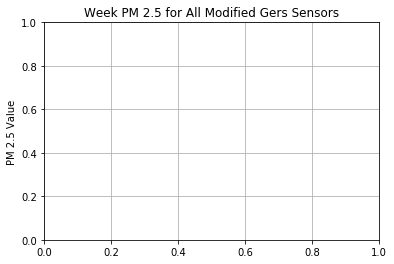

In [4]:
# all_modified_gers - This is the working boxplot for all_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

# Don't include sensors: FL, IA, KS, MB, NB, NJ, NL, OR, WA, WY
# Look more closely at: NE, NS

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
print(data.index[1])
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']

# start clean up data mode when in office or switched from outdoor to indoor or vice versa

# -------------------------- In Office ----------------------------------------------------------------------------------------------------------------------------
ak = data[data.index < '2020-02-15'].groupby("name").get_group('AK')
co = data[data.index < '2020-02-15'].groupby("name").get_group('CO')
ky = data[data.index < '2020-02-15'].groupby("name").get_group('KY')

# mb = data[data.index < '2020-02-15'].groupby("name").get_group('MB')
# mb = mb[(mb.index < '2020-01-26') | (mb.index >= '2020-02-04')]

# nj = data[(data.index < '2020-01-28') | (data.index >= '2020-02-04')].groupby("name").get_group('NJ')
nu = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('NU')
# oregon = data[(data.index < '2020-01-26') | (data.index >= '2020-02-04')].groupby("name").get_group('OR')
pe = data[(data.index < '2020-02-11')].groupby("name").get_group('PE') #outdoor sensor we are no longer using these sensors data
# wy = data[(data.index < '2020-02-11')].groupby("name").get_group('WY') 

# --------------------------------------- Switched ---------------------------------------------------------------------------------------------------------------

ab = data[(data.index > '2020-01-28') & (data.index <= '2020-02-14')].groupby("name").get_group('AB') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ns = data[(data.index >= '2020-01-28')].groupby("name").get_group('NS') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
# oregon = oregon[(oregon.index >= '2020-01-28')] # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor
ut = data[(data.index >= '2020-01-29')].groupby("name").get_group('UT') # outdoor sensor we are no longer using these sensors data before but will use after the switch to indoor

# finish clean up data mode when in office or switched from outdoor to indoor or vice versa
# ------------------------------------------------------------------------------------------------------------------------------------------------------

modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'ID', 'IL', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM', 'GA', 'ND', 'NE']
modified_gers_data = data[(data.name == modified_gers[0]) | (data.name == modified_gers[1]) | (data.name == modified_gers[2]) | (data.name == modified_gers[3]) | (data.name == modified_gers[4]) | (data.name == modified_gers[5]) | (data.name == modified_gers[6]) | (data.name == modified_gers[7]) | (data.name == modified_gers[8]) | (data.name == modified_gers[9]) | (data.name == modified_gers[10]) | (data.name == modified_gers[11]) | (data.name == modified_gers[12]) | (data.name == modified_gers[13]) | (data.name == modified_gers[14]) | (data.name == modified_gers[15]) | (data.name == modified_gers[16]) | (data.name == modified_gers[17]) | (data.name == modified_gers[18]) | (data.name == modified_gers[19]) | (data.name == modified_gers[20]) | (data.name == modified_gers[21])]
modified_gers_data = modified_gers_data.append(ak)
modified_gers_data = modified_gers_data.append(co)
modified_gers_data = modified_gers_data.append(ky)
# unmodified_gers = ['NJ', 'NS', 'NU', 'OK', 'OR', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
# unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5]) | (data.name == unmodified_gers[6]) | (data.name == unmodified_gers[7]) | (data.name == unmodified_gers[8]) | (data.name == unmodified_gers[9]) | (data.name == unmodified_gers[10])]

unmodified_gers = ['OK', 'PA', 'RI', 'SD', 'VA', 'WI']
unmodified_gers_data = data[(data.name == unmodified_gers[0]) | (data.name == unmodified_gers[1]) | (data.name == unmodified_gers[2]) | (data.name == unmodified_gers[3]) | (data.name == unmodified_gers[4]) | (data.name == unmodified_gers[5])]
unmodified_gers_data = unmodified_gers_data.append(ab)
# unmodified_gers_data = unmodified_gers_data.append(mb)
# unmodified_gers_data = unmodified_gers_data.append(nj)
unmodified_gers_data = unmodified_gers_data.append(nu)
unmodified_gers_data = unmodified_gers_data.append(ns)
# unmodified_gers_data = unmodified_gers_data.append(oregon)
unmodified_gers_data = unmodified_gers_data.append(ut)



All Sensors names: ['AB', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday',
       ...
       'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object', length=1000)
All Unmodified Gers list size: 6288186
whiskers:  [0.0, 298.0]
caps:  [0.0, 298.0]
boxes:  [16.0]
medians:  [45.0]
means:  [114.26667726552783]
fliers:  []


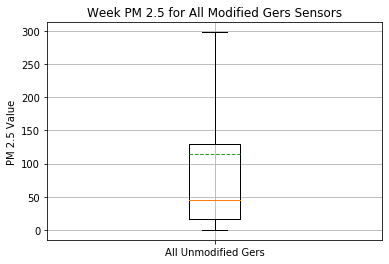

In [5]:
labels = ['All Unmodified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Modified Gers Sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in unmodified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = unmodified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:1000])

all_unmodified_gers = [unmodified_gers_data.pm2_5.dropna()]
print('{} list size: {}'.format(labels[0], len(data.pm2_5)))
results = plt.boxplot(all_unmodified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])



All Sensors names: ['AB', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
Mon list size: 158544
Tue list size: 165099
Wed list size: 166395
Thu list size: 177766
Fri list size: 173468
Sat list size: 171958
Sun list size: 162997
total for all days: 1176227

whiskers:  [0.0, 298.0, 0.0, 324.0, 0.0, 282.0, 0.0, 287.0, 0.0, 289.0, 0.0, 284.0, 0.0, 323.0]
caps:  [0.0, 298.0, 0.0, 324.0, 0.0, 282.0, 0.0, 287.0, 0.0, 289.0, 0.0, 284.0, 0.0, 323.0]
boxes:  [16.0, 17.0, 12.0, 15.0, 17.0, 17.0, 18.0]
medians:  [47.0, 47.0, 36.0, 43.0, 46.0, 46.0, 53.0]
means:  [117.39534135634271, 116.49923985002938, 106.21171309234052, 109.35284587603928, 114.57348329374871, 115.89169448353668, 120.50321785063528]
fliers:  []


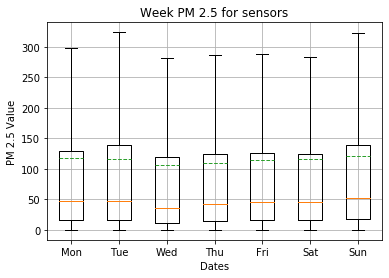

In [6]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)

all_sensors_names = []
for name, sensor_data in unmodified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = unmodified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = unmodified_gers_data[(unmodified_gers_data.index.day_name() == 'Monday')]['pm2_5'].dropna()
tuesday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Tuesday']['pm2_5'].dropna()
wednesday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Wednesday']['pm2_5'].dropna()
thursday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Thursday']['pm2_5'].dropna()
friday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Friday']['pm2_5'].dropna()
saturday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Saturday']['pm2_5'].dropna()
sunday = unmodified_gers_data[unmodified_gers_data.index.day_name() == 'Sunday']['pm2_5'].dropna()
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])



All Sensors names: ['AB', 'NS', 'NU', 'OK', 'PA', 'RI', 'SD', 'UT', 'VA', 'WI']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
Monday - AB list size: 1887
Monday - AB list size of data above 1000: 0
Monday - NS list size: 9988
Monday - NS list size of data above 1000: 0
Monday - NU list size: 11475
Monday - NU list size of data above 1000: 0
Monday - OK list size: 19895
Monday - OK list size of data above 1000: 0
Monday - PA list size: 20157
Monday - PA list size of data above 1000: 0
Monday - RI list size: 15027
Monday - RI list size of data above 1000: 0
Monday - SD list size: 27142
Monday - SD list size of data above 1000: 0
Monday - UT list size: 14367
Monday - UT list size of data above 1000: 0
Monday - VA list size: 30208
Monday - VA list size of data above 1000: 0
Monday - WI list size: 31669
Monday - WI list size of data above 1000: 0
Monday total: 

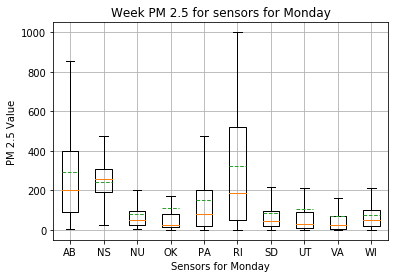

Tuesday - AB list size: 3182
Tuesday - AB list size of data above 1000: 0
Tuesday - NS list size: 11508
Tuesday - NS list size of data above 1000: 0
Tuesday - NU list size: 14436
Tuesday - NU list size of data above 1000: 0
Tuesday - OK list size: 18941
Tuesday - OK list size of data above 1000: 0
Tuesday - PA list size: 20048
Tuesday - PA list size of data above 1000: 0
Tuesday - RI list size: 16723
Tuesday - RI list size of data above 1000: 0
Tuesday - SD list size: 27085
Tuesday - SD list size of data above 1000: 0
Tuesday - UT list size: 14388
Tuesday - UT list size of data above 1000: 0
Tuesday - VA list size: 30375
Tuesday - VA list size of data above 1000: 0
Tuesday - WI list size: 32146
Tuesday - WI list size of data above 1000: 0
Tuesday total: 188832

whiskers:  [9.0, 513.0, 0.0, 718.0, 1.0, 204.0, 0.0, 150.0, 1.0, 449.0, 0.0, 1000.0, 0.0, 267.0, 0.0, 186.0, 0.0, 199.0, 0.0, 264.0]
caps:  [9.0, 513.0, 0.0, 718.0, 1.0, 204.0, 0.0, 150.0, 1.0, 449.0, 0.0, 1000.0, 0.0, 267.0, 0.

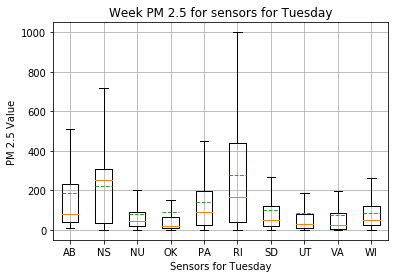

Wednesday - AB list size: 1444
Wednesday - AB list size of data above 1000: 0
Wednesday - NS list size: 10121
Wednesday - NS list size of data above 1000: 0
Wednesday - NU list size: 14557
Wednesday - NU list size of data above 1000: 0
Wednesday - OK list size: 18599
Wednesday - OK list size of data above 1000: 0
Wednesday - PA list size: 21099
Wednesday - PA list size of data above 1000: 0
Wednesday - RI list size: 16772
Wednesday - RI list size of data above 1000: 0
Wednesday - SD list size: 27149
Wednesday - SD list size of data above 1000: 0
Wednesday - UT list size: 15841
Wednesday - UT list size of data above 1000: 0
Wednesday - VA list size: 31373
Wednesday - VA list size of data above 1000: 0
Wednesday - WI list size: 33029
Wednesday - WI list size of data above 1000: 0
Wednesday total: 189984

whiskers:  [1.0, 722.0, 0.0, 709.0, 0.0, 192.0, 0.0, 116.0, 0.0, 334.0, 0.0, 1000.0, 0.0, 278.0, 0.0, 147.0, 0.0, 169.0, 1.0, 247.0]
caps:  [1.0, 722.0, 0.0, 709.0, 0.0, 192.0, 0.0, 116.

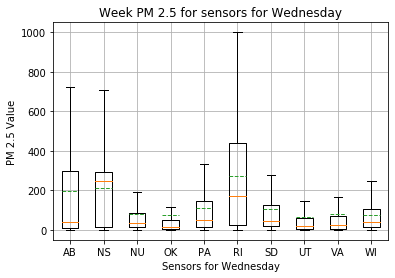

Thursday - AB list size: 1440
Thursday - AB list size of data above 1000: 0
Thursday - NS list size: 10080
Thursday - NS list size of data above 1000: 0
Thursday - NU list size: 14067
Thursday - NU list size of data above 1000: 0
Thursday - OK list size: 18720
Thursday - OK list size of data above 1000: 0
Thursday - PA list size: 21745
Thursday - PA list size of data above 1000: 0
Thursday - RI list size: 17270
Thursday - RI list size of data above 1000: 0
Thursday - SD list size: 28406
Thursday - SD list size of data above 1000: 0
Thursday - UT list size: 15837
Thursday - UT list size of data above 1000: 0
Thursday - VA list size: 31683
Thursday - VA list size of data above 1000: 0
Thursday - WI list size: 33080
Thursday - WI list size of data above 1000: 0
Thursday total: 192328

whiskers:  [18.0, 525.0, 0.0, 729.0, 2.0, 195.0, 0.0, 144.0, 0.0, 339.0, 1.0, 1000.0, 0.0, 260.0, 1.0, 183.0, 0.0, 209.0, 1.0, 234.0]
caps:  [18.0, 525.0, 0.0, 729.0, 2.0, 195.0, 0.0, 144.0, 0.0, 339.0, 1.0,

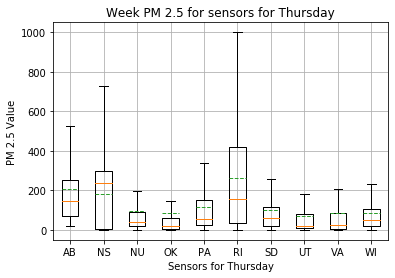

Friday - AB list size: 1791
Friday - AB list size of data above 1000: 0
Friday - NS list size: 7455
Friday - NS list size of data above 1000: 0
Friday - NU list size: 14399
Friday - NU list size of data above 1000: 0
Friday - OK list size: 18539
Friday - OK list size of data above 1000: 0
Friday - PA list size: 21598
Friday - PA list size of data above 1000: 0
Friday - RI list size: 17278
Friday - RI list size of data above 1000: 0
Friday - SD list size: 28682
Friday - SD list size of data above 1000: 0
Friday - UT list size: 15827
Friday - UT list size of data above 1000: 0
Friday - VA list size: 32547
Friday - VA list size of data above 1000: 0
Friday - WI list size: 33113
Friday - WI list size of data above 1000: 0
Friday total: 191229

whiskers:  [19.0, 1000.0, 0.0, 791.0, 2.0, 219.0, 1.0, 166.0, 1.0, 377.0, 1.0, 1000.0, 2.0, 263.0, 0.0, 126.0, 0.0, 190.0, 1.0, 269.0]
caps:  [19.0, 1000.0, 0.0, 791.0, 2.0, 219.0, 1.0, 166.0, 1.0, 377.0, 1.0, 1000.0, 2.0, 263.0, 0.0, 126.0, 0.0, 190

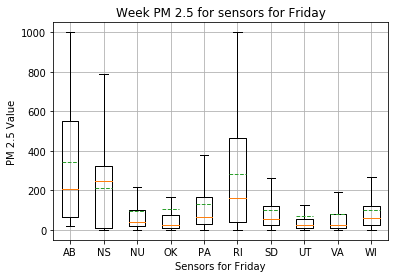

Saturday - AB list size: 2349
Saturday - AB list size of data above 1000: 0
Saturday - NS list size: 7491
Saturday - NS list size of data above 1000: 0
Saturday - NU list size: 13894
Saturday - NU list size of data above 1000: 0
Saturday - OK list size: 21093
Saturday - OK list size of data above 1000: 0
Saturday - PA list size: 22161
Saturday - PA list size of data above 1000: 0
Saturday - RI list size: 17277
Saturday - RI list size of data above 1000: 0
Saturday - SD list size: 28922
Saturday - SD list size of data above 1000: 0
Saturday - UT list size: 15836
Saturday - UT list size of data above 1000: 0
Saturday - VA list size: 32824
Saturday - VA list size of data above 1000: 0
Saturday - WI list size: 33110
Saturday - WI list size of data above 1000: 0
Saturday total: 194957

whiskers:  [13.0, 480.0, 105.0, 502.0, 3.0, 215.0, 1.0, 223.0, 0.0, 417.0, 2.0, 1000.0, 1.0, 212.0, 0.0, 221.0, 0.0, 171.0, 1.0, 199.0]
caps:  [13.0, 480.0, 105.0, 502.0, 3.0, 215.0, 1.0, 223.0, 0.0, 417.0, 2

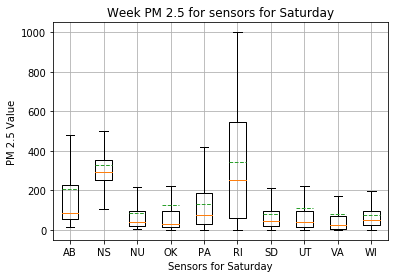

Sunday - AB list size: 1559
Sunday - AB list size of data above 1000: 0
Sunday - NS list size: 9091
Sunday - NS list size of data above 1000: 0
Sunday - NU list size: 11180
Sunday - NU list size of data above 1000: 0
Sunday - OK list size: 21516
Sunday - OK list size of data above 1000: 0
Sunday - PA list size: 21504
Sunday - PA list size of data above 1000: 0
Sunday - RI list size: 16848
Sunday - RI list size of data above 1000: 0
Sunday - SD list size: 28768
Sunday - SD list size of data above 1000: 0
Sunday - UT list size: 14632
Sunday - UT list size of data above 1000: 0
Sunday - VA list size: 31566
Sunday - VA list size of data above 1000: 0
Sunday - WI list size: 31912
Sunday - WI list size of data above 1000: 0
Sunday total: 188576

whiskers:  [11.0, 451.0, 95.0, 566.0, 1.0, 273.0, 1.0, 155.0, 1.0, 474.0, 1.0, 1000.0, 0.0, 267.0, 1.0, 270.0, 0.0, 188.0, 2.0, 273.0]
caps:  [11.0, 451.0, 95.0, 566.0, 1.0, 273.0, 1.0, 155.0, 1.0, 474.0, 1.0, 1000.0, 0.0, 267.0, 1.0, 270.0, 0.0, 188

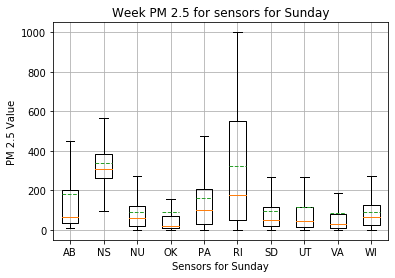

In [7]:
# modified_gers each sensors - This is the working boxplot for modified_gers only Mongolia deployed sensors

plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

all_sensors_names = []
for name, sensor_data in unmodified_gers_data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = unmodified_gers_data.index.day_name()
print(type(day_names))
print(day_names[:10])

for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = unmodified_gers_data[unmodified_gers_data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].dropna().to_numpy().tolist())
        cumulative += len(sensor_data)
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
        print('{} - {} list size of data above 1000: {}'.format(day, name,  len(sensor_data[sensor_data.pm2_5 > 1000])))
    print ('{} total: {}'.format(day, cumulative))    
    print()
    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()
    